# Trust the Gaussian Process

## Part I: Implementing Simple 1-D GP Regression using NumPy

![](img/nick-fewings-GYxdOemq6NA-unsplash.jpg)
<span>Photo by <a href="https://unsplash.com/@jannerboy62?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Nick Fewings</a> on <a href="https://unsplash.com/s/photos/curves?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

If you're reading this, then most likely you are either familiar with Gaussian Processes (and GP Regression), or at least, interested enough to explore the technique. That is basically where I was coming from. GP regression has been on my *todo* list of techniques to learn for a while now. Uh, quite a while. I bought *the book*...wait for it...

![](img/the_book.png)

I'm not going to go into the theory of GP's. For that, seriously, you should go buy *the book*. If you don't want *the book*, there are plenty of blog posts and YouTube videos on it. Here's a [nice visual introduction](https://distill.pub/2019/visual-exploration-gaussian-processes/) to the theory. There was something I felt was missing from all these resources, however, and that is HOW DO YOU ACTUALLY DO IT? I see the big scary equations, but how do we actually go about calculating these *things* in real code. Having a few days off at the end of 2020, I decided it was finally time for me to bite the bullet and get down to the business of *doing* GPs. In this post, I will go through some of the very first pages of *the book*, which explain the basic GP regression ideas, showing you the equations and how to implement them very simply using just plain Python and NumPy. Let's gooo!

We hardly need to load anything.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Kernels

Kernels aren't really discussed in detail until later in *the book*, but we need some concrete implementation to get anything to work. The good news is the kernels are extremely easy to implement, and in fact, all of the common ones can be written using a single line of NumPy code. Here are the equations followed by the Python functions.

*RBF*


$k(x,z) = \sigma^2\exp\left(-0.5 \times \frac{|x-z|^2}{l^2}\right).$

*Brownian*

$k(x,z)=\begin{cases}\sigma^2\min(|x|,|z|),& \text{if } x\cdot z\ge 0\\
        0, & \text{otherwise}. \end{cases}$
       
*Cosine*

$k(x,z) = \sigma^2 \cos\left(\frac{|x-z|}{l}\right).$

*Exponential*

$k(x, z) = \sigma^2\exp\left(-\frac{|x-z|}{l}\right).$

*Matern32*

$k(x, z) = \sigma^2\left(1 + \sqrt{3} \times \frac{|x-z|}{l}\right)
        \exp\left(-\sqrt{3} \times \frac{|x-z|}{l}\right).$
        
*Matern52*

$k(x,z)=\sigma^2\left(1+\sqrt{5}\times\frac{|x-z|}{l}+\frac{5}{3}\times
        \frac{|x-z|^2}{l^2}\right)\exp\left(-\sqrt{5} \times \frac{|x-z|}{l}\right).$
        
*Periodic*

$k(x,z)=\sigma^2\exp\left(-2\times\frac{\sin^2(\pi(x-z)/p)}{l^2}\right)$

*Polynomial*

$k(x, z) = \sigma^2(\text{bias} + x \cdot z)^d.$

*RationalQuadratic*

$k(x, z) = \sigma^2 \left(1 + 0.5 \times \frac{|x-z|^2}{\alpha l^2}
        \right)^{-\alpha}.$

In [30]:
def RBF(x,y,σ,λ):
    return (σ**2)*np.exp(-0.5*np.subtract.outer(x,y)**2/λ**2)

def Brownian(x,y,σ):
    return np.ma.masked_where(np.outer(x,y)<0,σ**2*np.minimum.outer(np.abs(x),np.abs(y))).filled(0)

def Cosine(x,y,σ,λ):
    return σ**2*np.cos(np.abs(np.subtract.outer(x,y))/λ)

def Exponential(x,y,σ,λ):
    return σ**2*np.exp(-np.abs(np.subtract.outer(x,y))/λ)

def Matern32(x,y,σ,λ):
    return σ**2*(1+np.sqrt(3)*np.abs(np.subtract.outer(x,y)/λ))*np.exp(-np.sqrt(3)*np.abs(np.subtract.outer(x,y)))

def Matern52(x,y,σ,λ):
    return σ**2*(1+np.sqrt(5)*np.abs(np.subtract.outer(x,y)/λ) + (5./3)*np.square(np.abs(np.subtract.outer(x,y))/λ**2))*np.exp(-np.sqrt(5)*np.abs(np.subtract.outer(x,y)))

def Periodic(x,y,σ,λ,p):
    return σ**2*np.exp(-2*np.square(np.sin(np.pi*np.subtract.outer(x,y)/p)/λ**2))

def Polynomial(x,y,σ,β,δ):
    return σ**2*np.power(β+np.outer(x,y),δ)

def RationalQuadratic(x,y,σ,λ,α):
    return σ**2*np.power(1.+0.5*np.square(np.abs(np.subtract.outer(x,y)))/(α*λ**2),-α)

Let's look at a few kernel realizations using a 1-D set of points $x_i$ ${i=1,2,...}$

In [34]:
def plot_heatmap(m, x, y):
    g = sns.heatmap(m)

    g.set_xticks(list(range(len(x))))
    g.set_xticklabels([round(i,1) for i in x],rotation=90)
    g.set_yticks(list(range(len(y))))
    g.set_yticklabels([round(-i,1) for i in y],rotation=0)

In [35]:
x = np.linspace(-1,1,20)

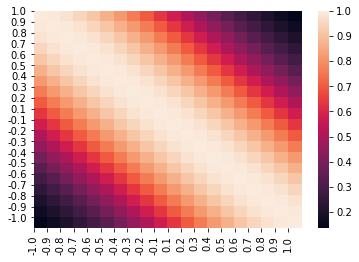

In [36]:
m = RBF(x,x,1,1)
plot_heatmap(m,x,x)

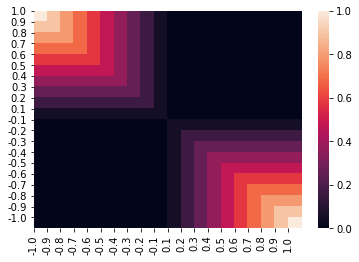

In [37]:
m = Brownian(x,x,1)
plot_heatmap(m,x,x)

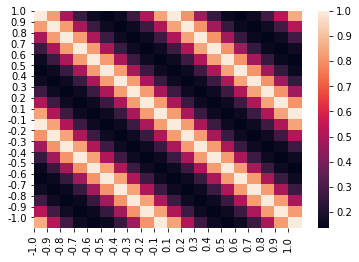

In [43]:
m = Periodic(x,x,1,1,np.pi/3)
plot_heatmap(m,x,x)

### Sampling from the Prior

Before we even have observations or targets to fit, we can plot some samples from the prior distribution. The key point here is that we are sampling from a distribution over *functions*, so each draw is actually a unique function. It's really very cool. And as it turns out very easy to implement in NumPy.

$\mathbf{f_*} \sim \mathcal{N}(\mathbf{0},K(X_*,X_*))$

What this equation (eq. 2.17 *the book*) says is that our sample function is normally distributed with zero mean and covariance given by one of the kernels applied to a set of test points (in our example this will just be $x_i$).

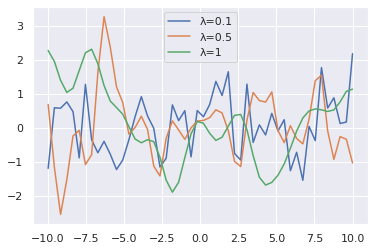

In [50]:
x = np.linspace(-10,10,50)
g = sns.lineplot()
sns.set_palette("colorblind")
sns.set_theme(style="darkgrid")

#trying a few different length scales here
for i,n in enumerate([0.1,0.5,1]):
    N = np.random.multivariate_normal(np.zeros(len(x)), RBF(x,x,1,n),1)
    g.plot(x,N[0],label=f'λ={n}')
    g.legend()

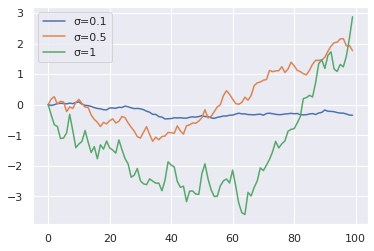

In [53]:
x = np.linspace(0,10,100)
g = sns.lineplot()
sns.set_palette("colorblind")
sns.set_theme(style="darkgrid")

for i,n in enumerate([0.1,0.5,1]):
    N = np.random.multivariate_normal(np.zeros(len(x)), Brownian(x,x,n),1)
    g.plot(N[0],label=f'σ={n}')
    g.legend()

I highly encourage you to play around with the different kernels and parameters. There's no better way to get a feel for it.

## Prediction with Noise-free Observations

Now we are ready to add some observations and perform very simple 1-D inference. The equation we want to replicate in code is eq. 2.19 from *the book*:

$\mathbf{f_*}|X_*,X,\mathbf{f}\sim\mathcal{N}(K(X_*,X)K(X,X)^{-1}\mathbf{f},K(X_*,X_*)-K(X_*,X)K(X,X)^{-1}K(X,X_*))$

Yes, that equation looks kind of scary and ridiculous, but that's why I wanted to write this up. It's actually not that bad when you figure it out in code. The most important thing in the equation is to understand the difference between $X$ and $X_*$. In the notation that *the book* uses, the $X_*$ vector is our test points. In other words, these are the points in function space that we want to make predictions. The $X$ are the training points, eg the points where we are given data or observations of our function. Likewise, $\mathbf{f}$ is the value of the observations at each of the training points $X$, and $\mathbf{f_*}$ are the predictions we are interested in calculating. In machine learning $\mathbf{f}$ would typically be called $\mathbf{y}$.

So let's create some fake observations that we can use for the calculations. Here I'm just sampling a very basic sin wave.

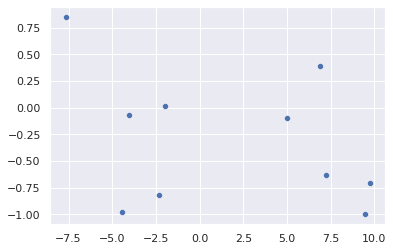

In [68]:
x = 20*(np.random.rand(10)-0.5)
f = np.sin(np.pi*x)
sns.scatterplot(x=x,y=f)
sns.set_theme(style="darkgrid")

Now we define the test points $X_*$ and all the covariance functions using the RBF kernel. I'm printing out the dimensions here so you can see that all the math will work out.

In [69]:
xstar = np.linspace(-10,10,100)
K_x_xstar = RBF(x,xstar,1,1)
K_xstar_x = RBF(xstar,x,1,1)
K_x_x = RBF(x,x,1,1)
K_xstar_xstar = RBF(xstar,xstar,1,1)
print(f'K_x_xstar.shape={K_x_xstar.shape}')
print(f'K_xstar_x.shape={K_xstar_x.shape}')
print(f'K_x_x.shape={K_x_x.shape}')
print(f'K_xstar_xstar.shape={K_xstar_xstar.shape}')
print(f'f.shape={f.shape}')
print(f'x.shape={x.shape}')
print(f'xstar.shape={xstar.shape}')

K_x_xstar.shape=(10, 100)
K_xstar_x.shape=(100, 10)
K_x_x.shape=(10, 10)
K_xstar_xstar.shape=(100, 100)
f.shape=(10,)
x.shape=(10,)
xstar.shape=(100,)


Here is the meat of the calculation. It's actually pretty straightforward matrix multiplication. $\sigma$ will be useful for visualizing confidence intervals.

In [70]:
μ = np.dot(np.dot(K_xstar_x,np.linalg.inv(K_x_x)),f)
Σ = K_xstar_xstar - np.dot(np.dot(K_xstar_x,np.linalg.inv(K_x_x)),K_x_xstar)
σ = np.sqrt(np.diag(Σ))
print(f'μ.shape={μ.shape}',f'Σ.shape={Σ.shape}',σ.shape)

μ.shape=(100,) Σ.shape=(100, 100) (100,)


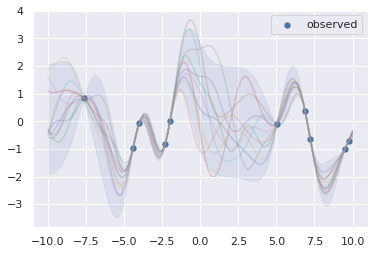

In [71]:
fstar = np.random.multivariate_normal(μ,Σ,10)
g=sns.scatterplot(x=x,y=f,s=50,label='observed')
for i in range(10):
    sns.lineplot(x=xstar,y=fstar[i],alpha=0.25)
g.fill_between(xstar,μ-2*σ,μ+2*σ,color='C0',alpha=0.1)

That's pretty cool! Where we have training data the function space is very well defined, but you can see where there is a lack of training data, the functions are allowed to wiggle all over the place ("wiggle all over the place" being the proper technical term, of course). Let's try a Brownian motion kernel instead.

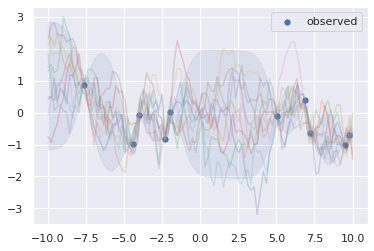

In [72]:
K_x_xstar = Brownian(x,xstar,1)
K_xstar_x = Brownian(xstar,x,1)
K_x_x = Brownian(x,x,1)
K_xstar_xstar = Brownian(xstar,xstar,1)
μ = np.dot(np.dot(K_xstar_x,np.linalg.inv(K_x_x)),f)
Σ = K_xstar_xstar - np.dot(np.dot(K_xstar_x,np.linalg.inv(K_x_x)),K_x_xstar)
fstar = np.random.multivariate_normal(μ,Σ,10)
g=sns.scatterplot(x=x,y=f,s=50,label='observed')
for i in range(10):
    sns.lineplot(x=xstar,y=fstar[i],alpha=0.25)
g.fill_between(xstar,μ-2*σ,μ+2*σ,color='C0',alpha=0.1)

It's the same idea, except the wiggles now have even more wiggles! I encourage you to try other kernels and other types of training data and explore what happens.

## Predicting Noisy Observations

So the last part of this piece is to inject some measurement noise or uncertainty. It turns out this literally just requires the addition of one term, $\sigma_n^2I$, which we include in the calculation of $K(X,X)$. This is eq. 2.22-24 in *the book*.

$\mathbf{f_*}|X_*,X,\mathbf{f}\sim\mathcal{N}(K(X_*,X)[K(X,X)+\sigma_n^2I]^{-1}\mathbf{f},K(X_*,X_*)-K(X_*,X)K(X,X)^{-1}K(X,X_*))$

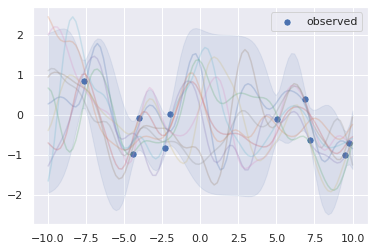

In [80]:
xstar = np.linspace(-10,10,100)
σ_n = 0.3 # setting the measurement "noise"
K_x_xstar = RBF(x,xstar,1,1)
K_xstar_x = RBF(xstar,x,1,1)
K_x_x = RBF(x,x,1,1)+σ_n**2*np.eye(len(x)) # here is where we insert \sigma_n
K_xstar_xstar = RBF(xstar,xstar,1,1)
μ = np.dot(np.dot(K_xstar_x,np.linalg.inv(K_x_x)),f)
Σ = K_xstar_xstar - np.dot(np.dot(K_xstar_x,np.linalg.inv(K_x_x)),K_x_xstar)
σ = np.sqrt(np.diag(Σ))
fstar = np.random.multivariate_normal(μ,Σ,10)
g=sns.scatterplot(x=x,y=f,s=50,label='observed')
for i in range(10):
    sns.lineplot(x=xstar,y=fstar[i],alpha=0.25)
g.fill_between(xstar,μ-2*σ,μ+2*σ,color='C0',alpha=0.1)

You can see what happens is now the GP is allowed to stray from the actual data.

Ok, well that covers the first few sections of Ch. 2 of *the book*. Hopefully, a Part 2 to follow soon!

### Please Leave A Github Star!